In [5]:
from scipy.stats import truncnorm
import pandas as pd
import numpy as np
import itertools
import datetime
import tqdm
import sys
import os

def flatten_list(list_array):
    return list(itertools.chain(*list_array))

sys.path.insert(0,"../")
from global_config import config

results_dir           = config.get_property('results_dir')
data_dir              = config.get_property('data_dir')
data_db_dir           = config.get_property('data_db_dir')
feb_hosp_records_path = os.path.join(data_db_dir, 'long_files_8_25_2021')
path_to_save          = os.path.join(results_dir, "real_testing", "community")


In [6]:
from utils.data_utils import load_movement_df, ward2size
from utils.plot_utils import *

path_to_data = os.path.join('..', '..', 'data')

# load scenarios for synthetic inferences
scenarios_df              = pd.read_csv(os.path.join(path_to_data, 'scenarios.csv'))
movement_df, ward2cluster = load_movement_df(path_to_data, True) # movement data
ward2size                 = ward2size(movement_df)
ward2size                 = {r.ward_id: r.num_patients for idx_r, r in ward2size.iterrows()}

/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_87301/1033347647.py:8: DtypeWarning: Columns (0,1,4,8) have mixed types.Specify dtype option on import or set low_memory=False.
  movement_df, ward2cluster = load_movement_df(path_to_data, True) # movement data


In [7]:

admissions_df = movement_df.copy().reset_index(); admissions_df = admissions_df[admissions_df.first_day==1].rename(columns={"first_day": "num_admissions"})
admissions_df = admissions_df.groupby(["ward_id", "date"]).sum()[["num_admissions"]]#.unstack([0]).sum().stack().reset_index()
admissions_df = admissions_df.reset_index()
admissions_df["day_of_week"] = admissions_df.date.dt.dayofweek

dayofweek2day                     = {0: "Monday", 1: "Tuesday", 2:"Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
admissions_week_df                = admissions_df.groupby("date").sum().reset_index(); admissions_week_df["day_of_week"] = admissions_week_df.date.dt.dayofweek
admissions_week_df["day_of_week"] = admissions_week_df["day_of_week"].replace(dayofweek2day)

ward_size_df = movement_df.copy().reset_index()
ward_size_df["num_patients"]= 1
ward_size_df = ward_size_df.groupby(["date", "ward_id"]).sum()[["num_patients"]].unstack([-1]).resample("1D").sum().stack().reset_index()
ward_size_df["date_map"] = ward_size_df["date"].map(lambda x: x.strftime('%d-%b'))


/var/folders/7p/jp6xqkvn5wb6ddl1fn0bhs980000gn/T/ipykernel_87301/625040098.py:49: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.set_ticklabels(ticksss)


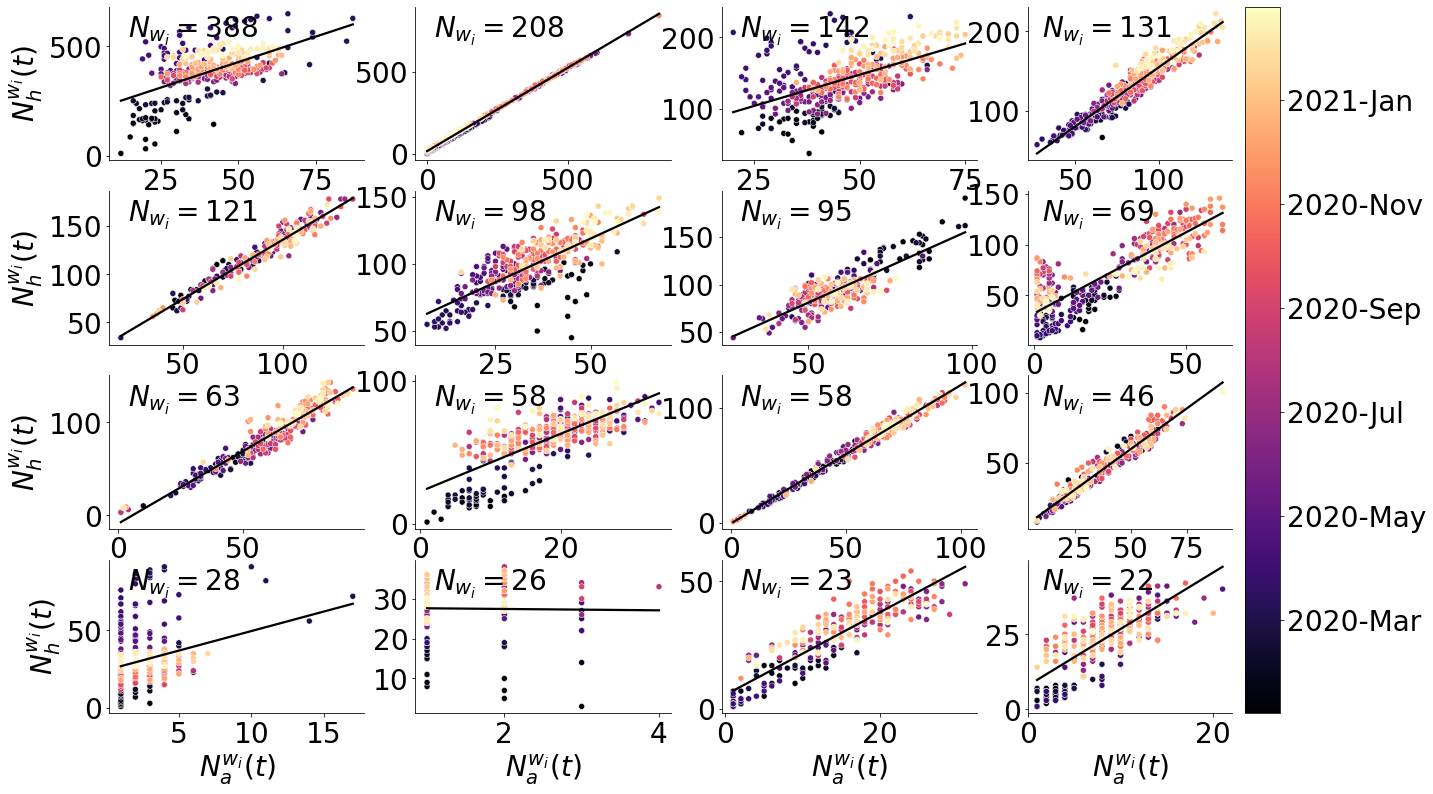

In [9]:
import seaborn as sns

all_ward_info_df = pd.merge(left=ward_size_df, right=admissions_df, how="inner")[["date", "ward_id", "num_patients", "num_admissions"]]
all_ward_info_df["ward_size"] = all_ward_info_df["ward_id"].map(ward2size)

all_ward_info_df["date_num"] = all_ward_info_df["date"].dt.strftime("%Y%m%d").astype(int)
top_10_big = np.flip(np.sort(all_ward_info_df.ward_size.unique()))

fig_dims = figure_size_setting(1900); fig_dims = [fig_dims[0], fig_dims[1]*1]

fig, axes = plt.subplots(4, 4, figsize=fig_dims)

PALETTE = "magma"#sns.light_palette("seagreen", as_cmap=True)

for idx_ward, ax in enumerate(axes.flatten()):

    sns.scatterplot(ax=ax, data=all_ward_info_df[all_ward_info_df.ward_size==top_10_big[idx_ward]], x ="num_admissions", y="num_patients", hue="date", palette=PALETTE, sizes=(10, 100), edgecolor="w")
    line_slope = sns.regplot(ax=ax, x="num_admissions", y="num_patients", data=all_ward_info_df[all_ward_info_df.ward_size==top_10_big[idx_ward]], scatter_kws={"s": 0}, ci=None, color="k")
    #ax.plot(range(10, 800), range(10, 800), lw=2, c="k", alpha=0.7)

    xlimsss = ax.get_xlim(); ylimsss = ax.get_ylim()

    ax.text(xlimsss[0]+(xlimsss[1]-xlimsss[0])/14, ylimsss[1]-(ylimsss[1]-ylimsss[0])/5, r"$N_{{w_i}}=${:.0f}".format(int(top_10_big[idx_ward])))
    ax.legend().remove()
    ax.set_ylabel(None)
    ax.set_xlabel(None)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.set_yscale("log")
    #ax.set_xscale("log")

axes[0,0].set_ylabel(r"$N_h^{w_i}(t)$")
axes[1,0].set_ylabel(r"$N_h^{w_i}(t)$")
axes[2,0].set_ylabel(r"$N_h^{w_i}(t)$")
axes[3,0].set_ylabel(r"$N_h^{w_i}(t)$")

axes[3, 0].set_xlabel(r"$N_a^{w_i}(t)$")
axes[3, 1].set_xlabel(r"$N_a^{w_i}(t)$")
axes[3, 2].set_xlabel(r"$N_a^{w_i}(t)$")
axes[3, 3].set_xlabel(r"$N_a^{w_i}(t)$")

norm = plt.Normalize(min(all_ward_info_df.date.unique()), max(all_ward_info_df.date.unique()))
sm   = plt.cm.ScalarMappable(cmap=PALETTE, norm=norm)
sm.set_array([])

cb      = fig.colorbar(sm, ax = axes[:,-1])
ticksss = [t.strftime("%Y-%b") for t in pd.to_datetime(cb.get_ticks())]
cb.set_ticklabels(ticksss)

#axes[0,0].legend(title="Date", loc="lower right", ncol=5, bbox_to_anchor=(3.5, 1.2))
#plt.tight_layout()

#path_to_save  = os.path.join(path_to_ms_figs, "admission_in_hospital_patients_per_ward.png")
#fig.savefig(path_to_save, dpi=300, transparent=True)